<a href="https://colab.research.google.com/github/titusss/PixelAlchemist/blob/main/PixelAlchemist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 18 02:27:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. **StyleCLIP Global Directions**

In [3]:
#@title StyleCLIP Setup

%tensorflow_version 1.x
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

!pip install pyngrok
!pip install flask-ngrok
!pip install flask==0.12.2

% cd
% cd /content/

!pip install ftfy regex tqdm 
!pip install git+https://github.com/openai/CLIP.git 
!git clone https://github.com/orpatashnik/StyleCLIP

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

%load_ext autoreload
%autoreload 2

TensorFlow 1.x selected.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.3 MB/s eta 0:04:03tcmalloc: large alloc 1147494400 bytes == 0x3a6f0000 @  0x7f5a78cf1615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:23tcmalloc: large alloc 1434370048 bytes == 0x7ed46000 @  0x7f5a78cf1615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 1156.7 MB 1.2 MB/s eta 0:00:01tcmalloc: large

In [4]:
#@title Download datasets
import gdown
from gdown import download as drive_download

global datasets
datasets = {
    'posters': {'name': 'posters',
     'npy': 'https://drive.google.com/drive/folders/1cwv9SsPtv2abOM47Mb7L7Xk4iyNbwndf',
     'pkl': 'https://drive.google.com/uc?id=1eaqnnqnzhPGdTXGMzSAd8YifMuooF0Qd',
     'neutral': 'A colorful piece of modern art'
     },
    'animals': {'name': 'animals',
     'npy': 'https://drive.google.com/drive/folders/10x9lqgHoU0OQIdQfZKRPDr2HI0b1s1U_',
     'pkl': 'https://drive.google.com/uc?id=1-qHksCZp_2yUf011ZasZqBdlwGZpnagT',
     'neutral': 'An animal in the wild'
    },
    'ffhq': {'name': 'ffhq',
     'npy': 'https://drive.google.com/drive/folders/1o7UCj8LthlT66Jf00fPwvZ41JJtv8Svv',
     'pkl': 'https://drive.google.com/uc?id=16oVGBwnasGz6g9-gSx4xlAJnW8M6evIg',
     'neutral': 'A face with eyes'
     },
    'churches': {'name': 'churches',
     'npy': 'https://drive.google.com/drive/folders/1xKMAsJvI4WzNTUWCkTZcUdasn6XbqIx_',
     'pkl': 'https://drive.google.com/uc?id=1hZFGANpBYnuU6TtgAEM81b5i2xHiREnL',
     'neutral': 'A church building'
     },
     'cars': {'name': 'cars',
      'npy': 'https://drive.google.com/drive/folders/1FBSeIWSDNC7dzXKLr4jPF1AIUxjLzHv7',
      'pkl': 'https://drive.google.com/uc?id=1NHmT5yMiN7KAdEUOo2ek8Hje5gtc-TVz',
      'neutral': 'A car'
     }
}

In [5]:
% cd
% cd /content/StyleCLIP/global_directions/npy

for d in datasets:
  print('Downloading StyleCLIP .npy files for:', d)
  gdown.download_folder(url=datasets[d]['npy'])

% cd
% cd /content/StyleCLIP/global_directions/model

for d in datasets:
  print('Downloading .pkl files for:', d)
  gdown.download(url=datasets[d]['pkl'])

/root
/content/StyleCLIP/global_directions/npy


Retrieving folder list


Processing file 1Lz_gCUE2NSYSL7bkV-iKXtfm8LAsZ4RJ fs3.npy
Processing file 1p8Vvosm075fvnuGBu5R--vbIRMtNeNlX S
Processing file 1UgrWs9pjCyXN5fQp12reu6zaYrS_cI3O S_mean_std
Processing file 1WKYjxtNCZ9TOI5zGV578Xf4LltHnPa-1 W.npy
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1Lz_gCUE2NSYSL7bkV-iKXtfm8LAsZ4RJ
To: /content/StyleCLIP/global_directions/npy/posters/fs3.npy
100%|██████████| 5.51M/5.51M [00:00<00:00, 23.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1p8Vvosm075fvnuGBu5R--vbIRMtNeNlX
To: /content/StyleCLIP/global_directions/npy/posters/S
100%|██████████| 71.7M/71.7M [00:00<00:00, 89.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UgrWs9pjCyXN5fQp12reu6zaYrS_cI3O
To: /content/StyleCLIP/global_directions/npy/posters/S_mean_std
100%|██████████| 73.7k/73.7k [00:00<00:00, 35.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WKYjxtNCZ9TOI5zGV578Xf4LltHnPa-1
To: /content/StyleCLIP/global_directions/npy/posters/W.npy
100%|██████████| 58.4M/58.4M [00:00<00:00, 74.7MB/s]
Download completed
Retrieving folder list


Processing file 176RdP1KJWand9bNlw7dFR_FnHw6f6abx fs3.npy
Processing file 1i2oI4tRr5vLllaDhLBgW0mlHnuOaWnKQ S
Processing file 1HmmrAjiu7o4Aq2PP0Vd1VmIrkYeR-8CJ S_mean_std
Processing file 1axB9ehfg2V12rVJGVS8lVL6zIZHQBXui W.npy
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=176RdP1KJWand9bNlw7dFR_FnHw6f6abx
To: /content/StyleCLIP/global_directions/npy/animals/fs3.npy
100%|██████████| 5.51M/5.51M [00:00<00:00, 19.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1i2oI4tRr5vLllaDhLBgW0mlHnuOaWnKQ
To: /content/StyleCLIP/global_directions/npy/animals/S
100%|██████████| 71.7M/71.7M [00:00<00:00, 90.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HmmrAjiu7o4Aq2PP0Vd1VmIrkYeR-8CJ
To: /content/StyleCLIP/global_directions/npy/animals/S_mean_std
100%|██████████| 73.7k/73.7k [00:00<00:00, 43.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1axB9ehfg2V12rVJGVS8lVL6zIZHQBXui
To: /content/StyleCLIP/global_directions/npy/animals/W.npy
100%|██████████| 205M/205M [00:01<00:00, 102MB/s]
Download completed
Retrieving folder list


Processing file 1VGVIhpQFEK8w7W_2KjHeT7UWX9unFuCv fs3.npy
Processing file 1lYAeo276SHEt0XwIt9tPqti7p2Fm3vEO S
Processing file 1FJP2-Z0rZhA6we15aDQIVuJBukp3PHEj S_mean_std
Processing file 1hCoolbV5cJqmyKO2jILG6RwgSma1Xtm- W.npy
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1VGVIhpQFEK8w7W_2KjHeT7UWX9unFuCv
To: /content/StyleCLIP/global_directions/npy/ffhq/fs3.npy
100%|██████████| 6.19M/6.19M [00:00<00:00, 36.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lYAeo276SHEt0XwIt9tPqti7p2Fm3vEO
To: /content/StyleCLIP/global_directions/npy/ffhq/S
100%|██████████| 72.7M/72.7M [00:01<00:00, 44.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FJP2-Z0rZhA6we15aDQIVuJBukp3PHEj
To: /content/StyleCLIP/global_directions/npy/ffhq/S_mean_std
100%|██████████| 75.1k/75.1k [00:00<00:00, 70.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hCoolbV5cJqmyKO2jILG6RwgSma1Xtm-
To: /content/StyleCLIP/global_directions/npy/ffhq/W.npy
100%|██████████| 205M/205M [00:02<00:00, 92.6MB/s]
Download completed
Retrieving folder list


Processing file 1nSV2LB73S4u2lW7F_pNJzxvrchqCspLg fs3.npy
Processing file 1N8YyisWR4_ceWiPYH0qv2YeWGMTsW9PU S
Processing file 1lDmiL5M3hfHr8St7Ac_3TD5UMbUUWiFh S_mean_std
Processing file 1xgFWt7HP1SYw_q-GEeW85OmLxs2pdXuJ W.npy
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1nSV2LB73S4u2lW7F_pNJzxvrchqCspLg
To: /content/StyleCLIP/global_directions/npy/churches/fs3.npy
100%|██████████| 5.51M/5.51M [00:00<00:00, 33.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1N8YyisWR4_ceWiPYH0qv2YeWGMTsW9PU
To: /content/StyleCLIP/global_directions/npy/churches/S
100%|██████████| 69.6M/69.6M [00:00<00:00, 71.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lDmiL5M3hfHr8St7Ac_3TD5UMbUUWiFh
To: /content/StyleCLIP/global_directions/npy/churches/S_mean_std
100%|██████████| 71.4k/71.4k [00:00<00:00, 18.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xgFWt7HP1SYw_q-GEeW85OmLxs2pdXuJ
To: /content/StyleCLIP/global_directions/npy/churches/W.npy
100%|██████████| 205M/205M [00:02<00:00, 76.3MB/s]
Download completed
Retrieving folder list


Processing file 1iS1Z6LX21ipdAbeJVIAEodHWWki_3GLn fs3.npy
Processing file 1DZMYJiQNjkZ5hJsAgbWlJiGP6limdahu S
Processing file 1ejYxoT38uRKMMMWzflePTKGgI0_DVrFr S_mean_std
Processing file 1m9SgyYIveHAtR9a3C2bp3qaeEl6NeZ-l W.npy
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1iS1Z6LX21ipdAbeJVIAEodHWWki_3GLn
To: /content/StyleCLIP/global_directions/npy/cars/fs3.npy
100%|██████████| 5.51M/5.51M [00:00<00:00, 32.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DZMYJiQNjkZ5hJsAgbWlJiGP6limdahu
To: /content/StyleCLIP/global_directions/npy/cars/S
100%|██████████| 71.7M/71.7M [00:01<00:00, 48.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ejYxoT38uRKMMMWzflePTKGgI0_DVrFr
To: /content/StyleCLIP/global_directions/npy/cars/S_mean_std
100%|██████████| 73.7k/73.7k [00:00<00:00, 21.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1m9SgyYIveHAtR9a3C2bp3qaeEl6NeZ-l
To: /content/StyleCLIP/global_directions/npy/cars/W.npy
100%|██████████| 205M/205M [00:03<00:00, 63.7MB/s]
Download completed


/root
/content/StyleCLIP/global_directions/model


Downloading...
From: https://drive.google.com/uc?id=1eaqnnqnzhPGdTXGMzSAd8YifMuooF0Qd
To: /content/StyleCLIP/global_directions/model/posters.pkl
100%|██████████| 364M/364M [00:04<00:00, 81.1MB/s]


Downloading...
From: https://drive.google.com/uc?id=1-qHksCZp_2yUf011ZasZqBdlwGZpnagT
To: /content/StyleCLIP/global_directions/model/animals.pkl
100%|██████████| 364M/364M [00:03<00:00, 102MB/s]


Downloading...
From: https://drive.google.com/uc?id=16oVGBwnasGz6g9-gSx4xlAJnW8M6evIg
To: /content/StyleCLIP/global_directions/model/ffhq.pkl
100%|██████████| 382M/382M [00:07<00:00, 51.6MB/s]


Downloading...
From: https://drive.google.com/uc?id=1hZFGANpBYnuU6TtgAEM81b5i2xHiREnL
To: /content/StyleCLIP/global_directions/model/churches.pkl
100%|██████████| 357M/357M [00:03<00:00, 102MB/s]


Downloading...
From: https://drive.google.com/uc?id=1NHmT5yMiN7KAdEUOo2ek8Hje5gtc-TVz
To: /content/StyleCLIP/global_directions/model/cars.pkl
100%|██████████| 364M/364M [00:04<00:00, 79.1MB/s]


In [6]:
global img_index
img_index =  1994#@param {type:"number"}
dataset_name='churches' #@param ['ffhq'] {allow-input: true}

In [7]:
#@title Set dataset

% cd
% cd /content/StyleCLIP/global_directions/

import tensorflow as tf
import gc
import numpy as np 
import torch
import clip
from PIL import Image
import pickle
import copy
import matplotlib.pyplot as plt
from MapTS import GetFs,GetBoundary,GetDt
from global_directions.manipulate import Manipulator
tf.reset_default_graph()
gc.collect()

def load_model(name, sess):
  print('Received session:', sess)
  if sess is not None:
    sess.close()
  tf.reset_default_graph()
  gc.collect()

  print('Active TF sessions:', tf.InteractiveSession._active_session_count)

  device = "cuda" if torch.cuda.is_available() else "cpu"
  model, preprocess = clip.load("ViT-B/32", device=device) 
  # input prepare data 
  # !python GetCode.py --dataset_name $dataset_name --code_type 'w' 
  # !python GetCode.py --dataset_name $dataset_name --code_type 's' 
  # !python GetCode.py --dataset_name $dataset_name --code_type 's_mean_std' 

  M=Manipulator(dataset_name=name)
  fs3=np.load('./npy/'+name+'/fs3.npy')
  np.set_printoptions(suppress=True)

  # img_index =  1995#@param {type:"number"}

  img_indexs=[img_index]
  dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]
  M.num_images=len(img_indexs)

  M.alpha=[0]
  M.manipulate_layers=[0]
  codes,out=M.EditOneC(0,dlatent_tmp) 
  original=Image.fromarray(out[0,0]).resize((512,512))
  M.manipulate_layers=None
  
  gc.collect()

  global active_dataset
  active_dataset = {
      'M': M,
      'fs3': fs3,
      'dlatent_tmp': dlatent_tmp,
      'model': model,
      'original': original
  }
  active_dataset['neutral'] = datasets[dataset_name]['neutral']

load_model(dataset_name, None)

/root
/content/StyleCLIP/global_directions
Received session: None
Active TF sessions: 0


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 103MiB/s]


Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.

Gs                            Params    OutputShape         WeightShape     
---                           ---       ---                 ---             
latents_in                    -         (?, 512)            -               
labels_in                     -         (?, 0)              -               
lod                           -         ()                  -               
dlatent_avg                   -         (512,)              -               
G_mapping/Normalize           -         (?, 512)            -               
G_mapping/Dense0              262656    (?, 512)            (512, 512)      
G_mapping/Dense1              262656    (?, 512)            (512, 512)      
G_mapping/Dense2              262656    (?, 512)            (512, 512)      
G_mapping/Dense3              262656    (?, 512)            (512, 512)   

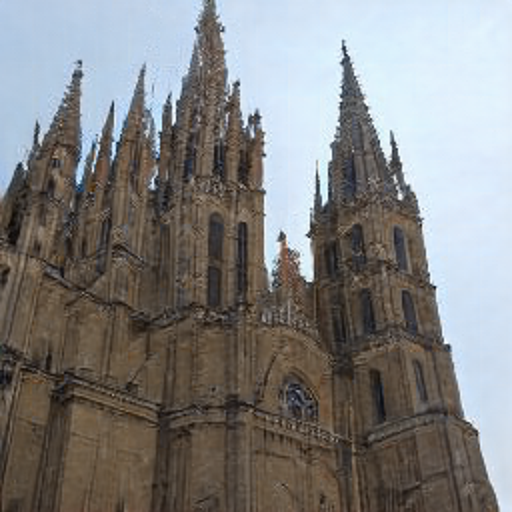

In [8]:
original = active_dataset['original']
original

In [9]:
global parameter_amount
parameter_amount =   1#@param {type:"integer", min: 1}

In [10]:
#@title Helper functions and default setup
from io import BytesIO
from flask import send_file, make_response
import base64

# Setup default values for sliders and text prompts
global params
params = {}
dts = []

for i in range(parameter_amount):
  # Default slider values
  params['p' + str(i)] = 'An photograph'
  params['a' + str(i)] = '4'
  params['b' + str(i)] = '0.15'
  # Compute prompt dts for default values
  target = params['p' + str(i)]
  neutral = active_dataset['neutral']
  model = active_dataset['model']
  classnames = [target,neutral]
  dts.append(GetDt(classnames,model))


def compute_prompts(index, target_prompt):
  neutral = active_dataset['neutral']
  model = active_dataset['model']

  classnames = [target_prompt,neutral]
  global dts
  dts[index] = GetDt(classnames,model)


def generate_frame(params, p_amount):
  d = active_dataset
  M, fs3, dlatent_tmp = d['M'], d['fs3'], d['dlatent_tmp']
  M.alpha=[1]
  # M.alpha=[float(params['a0'])]
  boundary=GetBoundary(fs3,dts[0],M,threshold=float(params['b0']))[0]
  boundary = np.multiply(boundary, float(params['a0']))

  for i in range(1, p_amount):
    M, fs3, dlatent_tmp = d['M'], d['fs3'], d['dlatent_tmp']
    # M.alpha=[float(params['a'+ str(i)])]
    added_boundary = GetBoundary(fs3,dts[i],M,threshold=float(params['b' + str(i)]))[0]
    for j in range(len(boundary)):
      boundary[j] += added_boundary[j] * float(params['a'+ str(i)])
      # * (float(params['a'+ str(i)]) / 10)

  
  # b_normalized = np.true_divide(boundary, p_amount)
  
  codes=M.MSCode(dlatent_tmp, boundary)
  out=M.GenerateImg(codes)
  return Image.fromarray(out[0,0])#.resize((512,512))


def serve_pil_img(pil_img):
  img_io = BytesIO()
  pil_img.save(img_io, 'jpeg', quality=70)
  img_io.seek(0)
  img = base64.b64encode(img_io.getvalue())
  return img

0.575


# 2. **Flask Server**

In [11]:
!ngrok authtoken 28wz03jWIKpBkiImk85EvpqU0N5_3JpJ2HDaMdohUurDNZadx

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [12]:
html_template_string = '''<!DOCTYPE html>
<html lang="en">

<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title>Test Image</title>
  <style>
    :root {
      --component-width: {{42 / p_amount}}vw;
      --component-height: 37vw;
    }

    body {
      margin: 0 !important;
      width: 100vw;
      font-family: sans-serif;
    }

    label {
      text-transform: uppercase;
      font-size: 14px;
      letter-spacing: 1px;
    }

    .wrapper {
      display: inline-block;
    }

    .image_wrapper {
      text-align: center;
      height: 49vw;
      width: 49vw;
      display: inline-block;
    }

    .faderWrapper {
      width: var(--component-width);
      height: var(--component-height);
      margin: auto;
      max-width: 40vw;
    }

    .faderField {
      background-color: #eaeaea;
      transform: rotate(270deg);
      transform-origin: calc(var(--component-height) / 2) calc(var(--component-height) / 2);
      height: var(--component-width);
      max-height: 40vw;
      width: var(--component-height);
      border-radius: 25px;
    }

    #new_picture {
      transition: opacity 450ms ease;
    }

    .allCenter {
      margin: 0;
      position: absolute;
      top: 50%;
      left: 50%;
      transform: translate(-50%, -50%);
    }

    input[type=text],
    input[type=range] {
      -webkit-appearance: none;
      /* Override default CSS styles */
      appearance: none;
      outline: none;
      border: 0px;
      padding: 8px;
    }

    input[type=text] {
      background-color: #eaeaea;
      border-radius: 10px;
      padding: 10px 0;
      margin: 10px 0;
      font-size: 17px;
      text-align: center;
      font-weight: 600;
    }

    #prompt {
      width: var(--component-width);
      max-width: 250px;
    }

    input[type=range] {
      -webkit-appearance: none;
      /* Override default CSS styles */
      appearance: none;
    }

    #alpha {
      width: 80%;
      /* Full-width */
      height: 3px;
      /* Specified height */
      background: #000;
      /* Grey background */
      border-radius: 100px;
      box-shadow: inset -2px 1px 2px rgba(0, 0, 0, 0.65), -1px 1px 0px #fff;
      background-image: linear-gradient(to bottom, #000 0%, #000 100%),
        linear-gradient(to bottom, #c6c6c6 0%, #c6c6c6 100%);
      background-clip: content-box, padding-box;
    }

    input[type=range]::-webkit-slider-thumb {
      -webkit-appearance: none;
      /* Override default look */
      appearance: none;
      cursor: pointer;
    }


    #alpha::-webkit-slider-thumb {
      width: 85px;
      /* Set a specific slider handle width */
      height: 50px;
      /* Slider handle height */
      background: linear-gradient(to left,
          rgba(193, 193, 193, 1) 0%,
          rgba(255, 255, 255, 1) 78%,
          rgba(162, 162, 162, 1) 79%,
          rgba(224, 224, 224, 1) 99%,
          rgba(193, 193, 193, 1) 100%);
      /* Cursor on hover */
      -moz-box-shadow: inset -1px 1px 0 #fff, -30px 0px 35px -15px rgba(0, 0, 0, 1);
      -webkit-box-shadow: inset -1px 1px 0 #fff,
        -30px 0px 35px 15px rgba(0, 0, 0, 1);
      box-shadow: inset -1px 1px 0 #fff, -30px 0px 35px -15px rgba(0, 0, 0, 1);
    }

    .form {
      text-align: center;
      width: 50vw;
      display: inline-block;
    }

    .button_div {
      background-color: #eaeaea;
      padding: 10px;
      font-weight: 600;
      border-radius: 20px;
      transition: background-color 250ms ease;
      cursor: pointer;
    }

    .button_div:hover {
      background-color: #A2A2A2;
    }
  </style>
</head>

<body>
  <div style="margin-top: 50px; display: flex; align-items: center;">
    <form class="form">
      {% if p_amount > 1 %}
      <div id="remove" class="control_p_amount" style="display: inline-block;">
        <div class="button_div" id="remove">-</div>
      </div>
      {% endif %}
      {% for i in range(p_amount) %}
      <div class="wrapper">
        <input id="beta" type="text" class="dial" data-min="0.08" data-max="0.3" data-step="0.01" value="{{ params[" b"
          + i|string] }}" name="b{{i}}" data-width=100 data-height=100 data-bgColor="#000000" data-fgColor="#eaeaea"
          data-angleOffset=-125 data-angleArc=250 data-rotation=anticlockwise>
        <div class="faderWrapper">
          <div class="faderField">
            <input id="alpha" class="input_slider faderSlider verticalSlider allCenter" type="range" min="-10" max="10"
              step="1" value="{{ params[" a" + i|string] }}" name="a{{i}}">
          </div>
        </div>
        <input class="input_text" id="prompt" type="text" name="p{{i}}" value="{{ params[" p"+i|string] }}"
          placeholder="Enter prompt...">
      </div>
      {% endfor %}
      <div id="add" class="control_p_amount" style="display: inline-block;">
        <div class="button_div" id="add">+</div>
      </div>
    </form>
    <div class="image_wrapper">
      <div
        style="background-color: #000; width: 49vw; height: 49vw; text-align: center; position: absolute; color: #fff; z-index: -10;">
        <h2 style="margin-top: 23vw;">Loading...</h2>
      </div>
      <img id="new_picture" src="{{initial_img}}" style="width: 49vw; height: 49vw; opacity: 1;">
      <div class="dataset_selection">
        {% for dataset in datasets %}
        <input type="radio" id="{{datasets[dataset]['name']}}" name="dataset">
        <label for="{{datasets[dataset]['name']}}">{{datasets[dataset]['name']}}</label>
        {% endfor %}
      </div>
    </div>
  </div>
  <script src="https://ajax.googleapis.com/ajax/libs/jquery/3.5.1/jquery.min.js"></script>
  <script type="text/javascript"
    src="https://cdnjs.cloudflare.com/ajax/libs/jQuery-Knob/1.2.13/jquery.knob.min.js"></script>
  <script>
    $(function () {
      $(".dial").knob();
    });
  </script>
</body>
<script>

  $.ajaxSetup({ cache: false });
  
  function throttle(f, delay) {
    var timer = null;
    return function () {
      var context = this, args = arguments;
      clearTimeout(timer);
      timer = window.setTimeout(function () {
        f.apply(context, args);
      },
        delay || 600);
    };
  }
  function updateImage() {
    $.ajax({
      cache: false,
      type: 'post',
      url: '/get_image_uri',
      data: $('form').serialize(),
      contentType: 'application/json;charset=UTF-8',
      success: function (data) {
        $('#new_picture').attr('src', data);
      },
      error: function (error) {
        console.log('An error occured: ');
        console.log(error);
      }
    });
  }
  $('.dial').knob({
    'change': function () {
      console.log('knob updated');
      updateImage();
    }
  });

  $(document).ready(function () {

    $('input[type=range]').on('input', function () {
      console.log('slider updated');
      updateImage();
    });

    $('.control_p_amount').on('click', function (e) {
      console.log(e.target)
      var target = new Object();
      var target = {
        id: e.target.id
      }
      $('#new_picture').css('opacity', '0.2')
      $.ajax({
        cache: false,
        type: 'post',
        url: '/change_p_amount',
        data: JSON.stringify(target),
        contentType: 'application/json;charset=UTF-8',
        success: function (data) {
          location.reload();
        },
        error: function (error) {
          console.log('An error occured: ');
          console.log(error);
        }
      });
    });

    $('input[type=radio]').on('click', function (e) {
      var target = new Object();
      var target = {
        name: e.target.id
      }
      $('#new_picture').css('opacity', '0.2')
      $.ajax({
        cache: false,
        type: 'post',
        url: '/set_dataset',
        data: JSON.stringify(target),
        contentType: 'application/json;charset=UTF-8',
        success: function (data) {
          location.reload();
        },
        error: function (error) {
          console.log('An error occured: ');
          console.log(error);
        }
      });
    });

    $('.input_text').keyup(throttle ( function (e) {
      console.log('Updating prompts...')
      var target = new Object();
      var target = {
        name: e.target.name,
        value: e.target.value
      }

      $.ajax({
        cache: false,
        type: 'post',
        url: '/update_prompts',
        data: JSON.stringify(target),
        contentType: 'application/json;charset=UTF-8',
        success: function (data) {
          // busy = false;
        },
        error: function (error) {
          console.log('An error occured: ');
          console.log(error);
          // busy = false;
        }
      });
    }));

  });
</script>

</html>'''

In [13]:
from flask import Flask, request, redirect, url_for, render_template, json, render_template_string, jsonify, Response
from flask_ngrok import run_with_ngrok
import random
from urllib import parse

app = Flask(__name__)
run_with_ngrok(app)

img_uri = serve_pil_img(active_dataset['original'])
initial_img = 'data:image/jpeg;base64,' + img_uri.decode('utf-8')

@app.route("/")
def index():
    return render_template_string(html_template_string, params=params, p_amount=parameter_amount, datasets=datasets, initial_img=initial_img)

@app.route("/get_image_uri", methods=['POST'])
def get_generated_image():
  args = request.data.decode('utf8')
  params = dict((parse.parse_qsl(args))) # Convert url args to params dict
  img = generate_frame(params, parameter_amount)
  img_uri = serve_pil_img(img)
  return 'data:image/jpeg;base64,' + img_uri.decode('utf-8')

@app.route("/update_prompts", methods=['POST'])
def prompts():
  p_data = json.loads(request.data.decode('utf8'))
  p_index = int(p_data['name'][1:])
  compute_prompts(p_index, p_data['value'])
  return 'Success'

@app.route("/set_dataset", methods=['POST'])
def update_dataset():
  global img_index
  global initial_img
  d_data = json.loads(request.data.decode('utf8'))
  img_index = random.randint(0, 1999) # Random first image
  load_model(d_data['name'], active_dataset['M'].sess)
  print('Updated dataset to', d_data['name'])
  img_uri = serve_pil_img(active_dataset['original'])
  initial_img = 'data:image/jpeg;base64,' + img_uri.decode('utf-8')
  return 'Success'

@app.route("/change_p_amount", methods=['POST'])
def update_p_amount():
  global parameter_amount
  global dts
  o_data = json.loads(request.data.decode('utf8'))
  if o_data['id'] == 'add':
    parameter_amount += 1
    dts.append(0)
    compute_prompts(len(dts) - 1, active_dataset['neutral'])
  elif o_data['id'] == 'remove' and parameter_amount > 1:
    parameter_amount -= 1
    dts.pop()
  return 'Success'
    

app.run()

# if __name__ == '__main__':
# app.run(debug=True, use_reloader=False)

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://bdea-34-141-217-229.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [18/May/2022 02:34:22] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:23] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:25] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:25] "GET /favicon.ico HTTP/1.1" 404 -
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
127.0.0.1 - - [18/May/2022 02:34:29] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 5376


127.0.0.1 - - [18/May/2022 02:34:29] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 33


127.0.0.1 - - [18/May/2022 02:34:30] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:30] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:30] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 33
num of channels being manipulated: 33
num of channels being manipulated: 33


127.0.0.1 - - [18/May/2022 02:34:30] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:30] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:30] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 33
num of channels being manipulated: 33
num of channels being manipulated: 33
num of channels being manipulated: 33


127.0.0.1 - - [18/May/2022 02:34:30] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:30] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:30] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 33
num of channels being manipulated: 33


127.0.0.1 - - [18/May/2022 02:34:34] "POST /update_prompts HTTP/1.1" 200 -


0.568


127.0.0.1 - - [18/May/2022 02:34:35] "POST /update_prompts HTTP/1.1" 200 -


0.5454


127.0.0.1 - - [18/May/2022 02:34:51] "POST /update_prompts HTTP/1.1" 200 -


0.568


127.0.0.1 - - [18/May/2022 02:34:51] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 96


127.0.0.1 - - [18/May/2022 02:34:52] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 13


127.0.0.1 - - [18/May/2022 02:34:52] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 13


127.0.0.1 - - [18/May/2022 02:34:53] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:53] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 13
num of channels being manipulated: 13
num of channels being manipulated: 13


127.0.0.1 - - [18/May/2022 02:34:53] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:53] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:53] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:53] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 13
num of channels being manipulated: 13
num of channels being manipulated: 13


127.0.0.1 - - [18/May/2022 02:34:53] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 13


127.0.0.1 - - [18/May/2022 02:34:53] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:53] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:53] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 13
num of channels being manipulated: 13
num of channels being manipulated: 13


127.0.0.1 - - [18/May/2022 02:34:54] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:54] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 13
num of channels being manipulated: 13
num of channels being manipulated: 13


127.0.0.1 - - [18/May/2022 02:34:54] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:54] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:54] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:54] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:54] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 13
num of channels being manipulated: 13
num of channels being manipulated: 13
num of channels being manipulated: 13


127.0.0.1 - - [18/May/2022 02:34:54] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:54] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:55] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:55] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 13
num of channels being manipulated: 13
num of channels being manipulated: 13
num of channels being manipulated: 13


127.0.0.1 - - [18/May/2022 02:34:55] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:55] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:55] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:55] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 13
num of channels being manipulated: 13
num of channels being manipulated: 13
num of channels being manipulated: 13


127.0.0.1 - - [18/May/2022 02:34:55] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:55] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:55] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:55] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 13
num of channels being manipulated: 13
num of channels being manipulated: 13
num of channels being manipulated: 13


127.0.0.1 - - [18/May/2022 02:34:55] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:55] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 13
num of channels being manipulated: 13


127.0.0.1 - - [18/May/2022 02:34:56] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:56] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 13
num of channels being manipulated: 96


127.0.0.1 - - [18/May/2022 02:34:57] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:57] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:34:57] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 96
num of channels being manipulated: 96
num of channels being manipulated: 96


127.0.0.1 - - [18/May/2022 02:34:57] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 96


/content/StyleCLIP/global_directions/MapTS.py:202: RuntimeWarning: invalid value encountered in true_divide
  dt=dt/np.linalg.norm(dt)
127.0.0.1 - - [18/May/2022 02:34:59] "POST /change_p_amount HTTP/1.1" 200 -


0.0


127.0.0.1 - - [18/May/2022 02:34:59] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:01] "POST /change_p_amount HTTP/1.1" 200 -


0.0


127.0.0.1 - - [18/May/2022 02:35:01] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:05] "POST /update_prompts HTTP/1.1" 200 -


0.6367


127.0.0.1 - - [18/May/2022 02:35:07] "POST /update_prompts HTTP/1.1" 200 -


0.6514


127.0.0.1 - - [18/May/2022 02:35:09] "POST /update_prompts HTTP/1.1" 200 -


0.2927


127.0.0.1 - - [18/May/2022 02:35:09] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:09] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 5376
num of channels being manipulated: 5376
num of channels being manipulated: 375
num of channels being manipulated: 5376
num of channels being manipulated: 5376
num of channels being manipulated: 5376


127.0.0.1 - - [18/May/2022 02:35:10] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 5376
num of channels being manipulated: 5376
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:11] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5376
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:12] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:12] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:12] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375
num of channels being manipulated: 19


127.0.0.1 - - [18/May/2022 02:35:12] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:12] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 5
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:12] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:12] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:13] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:13] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:13] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 5


127.0.0.1 - - [18/May/2022 02:35:13] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:16] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:16] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 3
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:17] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:17] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 3
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 3
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:17] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 3
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:17] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 3
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:18] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:18] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 3
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 3
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:18] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:18] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 3
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 3
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:18] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:18] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 3
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 3
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:19] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:19] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 7
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 3
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:20] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 7
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:20] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 7
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:22] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:22] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 7
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:23] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 5


127.0.0.1 - - [18/May/2022 02:35:24] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:24] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375
num of channels being manipulated: 19


127.0.0.1 - - [18/May/2022 02:35:24] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:24] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 5
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:25] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:25] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:25] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:25] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:25] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:25] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:25] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:25] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:26] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:26] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:27] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:27] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:27] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 5
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:34] "POST /update_prompts HTTP/1.1" 200 -


0.633


127.0.0.1 - - [18/May/2022 02:35:36] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:36] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1


127.0.0.1 - - [18/May/2022 02:35:36] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:37] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:37] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:37] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:37] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:37] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:37] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:37] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:38] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:38] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:38] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:38] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:38] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:38] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:38] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:38] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:39] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:39] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:39] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:39] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:39] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:39] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:39] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:39] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:39] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:40] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:40] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:40] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:40] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:40] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375


127.0.0.1 - - [18/May/2022 02:35:40] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:40] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
num of channels being manipulated: 19
num of channels being manipulated: 1
num of channels being manipulated: 375
Received session: <tensorflow.python.client.session.InteractiveSession object at 0x7fb0d6a4df50>
Active TF sessions: 0

Gs                            Params    OutputShape         WeightShape     
---                           ---       ---                 ---             
latents_in                    -         (?, 512)            -               
labels_in                     -         (?, 0)              -               
lod                           -         ()                  -               
dlatent_avg                   -         (512,)              -               
G_mapping/Normalize           -         (?, 512)            -               
G_mapping/Dense0              262656    (?, 512)            (512, 512)      
G_mapping/Dense1              262656

127.0.0.1 - - [18/May/2022 02:35:52] "POST /set_dataset HTTP/1.1" 200 -


Updated dataset to cars


127.0.0.1 - - [18/May/2022 02:35:52] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:35:55] "POST /update_prompts HTTP/1.1" 200 -


0.6167


127.0.0.1 - - [18/May/2022 02:36:01] "POST /update_prompts HTTP/1.1" 200 -


0.601


127.0.0.1 - - [18/May/2022 02:36:01] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 5376
num of channels being manipulated: 5376
num of channels being manipulated: 5376
num of channels being manipulated: 5376
num of channels being manipulated: 237
num of channels being manipulated: 5376


127.0.0.1 - - [18/May/2022 02:36:02] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:02] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 5376
num of channels being manipulated: 237
num of channels being manipulated: 5376


127.0.0.1 - - [18/May/2022 02:36:03] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 5376


127.0.0.1 - - [18/May/2022 02:36:03] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 5376
num of channels being manipulated: 93
num of channels being manipulated: 237


127.0.0.1 - - [18/May/2022 02:36:03] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 5376


127.0.0.1 - - [18/May/2022 02:36:04] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 5376


127.0.0.1 - - [18/May/2022 02:36:04] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 5376


127.0.0.1 - - [18/May/2022 02:36:06] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 5376


127.0.0.1 - - [18/May/2022 02:36:06] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 5376


127.0.0.1 - - [18/May/2022 02:36:07] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 5376


127.0.0.1 - - [18/May/2022 02:36:07] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 5376
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 5376


127.0.0.1 - - [18/May/2022 02:36:07] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:08] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 5376


127.0.0.1 - - [18/May/2022 02:36:08] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 5376


127.0.0.1 - - [18/May/2022 02:36:12] "POST /update_prompts HTTP/1.1" 200 -


0.6597
num of channels being manipulated: 93
num of channels being manipulated: 237

127.0.0.1 - - [18/May/2022 02:36:13] "POST /get_image_uri HTTP/1.1" 200 -
/content/StyleCLIP/global_directions/MapTS.py:216: RuntimeWarning: invalid value encountered in true_divide
  ds_imp/=tmp
127.0.0.1 - - [18/May/2022 02:36:13] "POST /get_image_uri HTTP/1.1" 200 -



num of channels being manipulated: 5376
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 0


127.0.0.1 - - [18/May/2022 02:36:14] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 0


127.0.0.1 - - [18/May/2022 02:36:14] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 0
num of channels being manipulated: 93
num of channels being manipulated: 237

127.0.0.1 - - [18/May/2022 02:36:14] "POST /get_image_uri HTTP/1.1" 200 -



num of channels being manipulated: 0


127.0.0.1 - - [18/May/2022 02:36:15] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 0


127.0.0.1 - - [18/May/2022 02:36:16] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 3
num of channels being manipulated: 93


127.0.0.1 - - [18/May/2022 02:36:16] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 237
num of channels being manipulated: 3


127.0.0.1 - - [18/May/2022 02:36:18] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 3


127.0.0.1 - - [18/May/2022 02:36:18] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 3
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 3


127.0.0.1 - - [18/May/2022 02:36:18] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:19] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 3


127.0.0.1 - - [18/May/2022 02:36:20] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 3


127.0.0.1 - - [18/May/2022 02:36:21] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 19
num of channels being manipulated: 93


127.0.0.1 - - [18/May/2022 02:36:21] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:21] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 237
num of channels being manipulated: 19
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 19


127.0.0.1 - - [18/May/2022 02:36:21] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 19
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 19


127.0.0.1 - - [18/May/2022 02:36:21] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:22] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 19
num of channels being manipulated: 93
num of channels being manipulated: 237


127.0.0.1 - - [18/May/2022 02:36:22] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 19


127.0.0.1 - - [18/May/2022 02:36:23] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 19


127.0.0.1 - - [18/May/2022 02:36:23] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 34
num of channels being manipulated: 93


127.0.0.1 - - [18/May/2022 02:36:24] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:24] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 237
num of channels being manipulated: 34
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 34


127.0.0.1 - - [18/May/2022 02:36:24] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 34


127.0.0.1 - - [18/May/2022 02:36:26] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 34


127.0.0.1 - - [18/May/2022 02:36:26] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:27] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77


127.0.0.1 - - [18/May/2022 02:36:27] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:27] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77


127.0.0.1 - - [18/May/2022 02:36:27] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:28] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77


127.0.0.1 - - [18/May/2022 02:36:29] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:29] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77


127.0.0.1 - - [18/May/2022 02:36:29] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:29] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77


127.0.0.1 - - [18/May/2022 02:36:29] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:29] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77


127.0.0.1 - - [18/May/2022 02:36:29] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:29] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77


127.0.0.1 - - [18/May/2022 02:36:29] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:30] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77


127.0.0.1 - - [18/May/2022 02:36:30] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:30] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77


127.0.0.1 - - [18/May/2022 02:36:30] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77


127.0.0.1 - - [18/May/2022 02:36:31] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77


127.0.0.1 - - [18/May/2022 02:36:31] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:31] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77


127.0.0.1 - - [18/May/2022 02:36:32] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77
num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77


127.0.0.1 - - [18/May/2022 02:36:33] "POST /get_image_uri HTTP/1.1" 200 -
127.0.0.1 - - [18/May/2022 02:36:33] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77


127.0.0.1 - - [18/May/2022 02:36:33] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 93
num of channels being manipulated: 237
num of channels being manipulated: 77
num of channels being manipulated: 93
num of channels being manipulated: 237


127.0.0.1 - - [18/May/2022 02:36:33] "POST /get_image_uri HTTP/1.1" 200 -


num of channels being manipulated: 77
